# Logistic回归与Softmax回归

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 数据准备

In [7]:
import itertools
import functools

class PolynomialFeature(object):
    """Polynomial features

    transforms input array with polynomial features

    Example 1
    =========
    x = [a, b]

    y = PolynomialFeature(degree=5).transform(x)
    y = [[1, a, a^2, a^3, a^4, a^5],
         [1, b, b^2, b^3, b^4, b^5]]

    Example 1
    =========
    x = [[a, b],
         [c, d]]

    y = PolynomialFeature(degree=2).transform(x)
    y = [[1, a, b, a^2, a*b, b^2],
         [1, c, d, c^2, c*d, d^2]]
    """
    def __init__(self, degree=2):
        """Construct polynomial features
        
        Params
        ======
        degree: int
          degree of polynomial
        """
        if not isinstance(degree, int):
            raise ValueError("degree should be int type")
        self.degree = degree

    def transform(self, x):
        """Transforms input array with polynomial features

        Params
        ======
        x: ndarray with shape (N, D)
           input array

        Returns
        =======
        output: ndarray with shape (N, K+1)
           polynomial features
        """
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree+1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.array(features).transpose()

In [8]:
def create_toy_data(add_outliers=False, add_class=False):
    x0 = np.random.normal(size=50).reshape(-1, 2) - 1
    x1 = np.random.normal(size=50).reshape(-1, 2) + 1
    if add_outliers:
        x2 = np.random.normal(size=10).reshape(-1, 2) + np.array([6., 3.])
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(30)]).astype(np.int)
    if add_class:
        x2 = np.random.normal(size=50).reshape(-1, 2) + 3.
        return np.concatenate([x0, x1, x2]), np.concatenate([np.zeros(25), np.ones(25), np.zeros(25)+2]).astype(np.int)
    return np.concatenate([x0, x1]), np.concatenate([np.zeros(25), np.ones(25)]).astype(np.int)

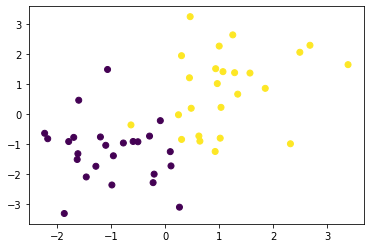

In [9]:
x_train, y_train = create_toy_data()
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)

## Logistic回归

$$
\nabla E(\vec w) = \vec Z^T(\vec y-\vec t)
$$
$$
\mathbf H = \mathbf Z^T \mathbf R \mathbf Z, \quad \mathbf R =(y_1(1-y_1),\cdots,y_N(1-y_N)
$$
$$
\vec w^{new} = \vec w^{old}-\mathbf H^{-1} \nabla E(\vec w)
$$
$$
\delta \vec w =\mathbf H^{-1} \nabla E(\vec w)
$$
$$
\mathbf H \delta \vec w=\nabla E(\vec w)
$$

In [13]:
class LogisticRegression(object):
    """
    Logistic regression model

    y = sigmoid(X @ w)
    t ~ Bernoulli(t|y)
    """

    @staticmethod 静态方法
    def _sigmoid(a):
        return np.tanh(a * 0.5) * 0.5 + 0.5

    def fit(self, X, t, max_iter=100):
        """
        maximum likelihood estimation of logistic regression model

        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
            binary 0 or 1
        max_iter : int, optional
            maximum number of paramter update iteration (the default is 100)
        """
        w = np.zeros(np.size(X, 1))
        for _ in range(max_iter):
            w_prev = np.copy(w)
            y = self._sigmoid(X @ w)
            grad = X.T @ (y - t)
            hessian = (X.T * y * (1 - y)) @ X
            try:
                w -= np.linalg.solve(hessian, grad)
            except np.linalg.LinAlgError:
                break
            if np.allclose(w, w_prev):
                break
        self.w = w

    def proba(self, X):
        """
        compute probability of input belonging class 1

        Parameters
        ----------
        X : (N, D) np.ndarray
            training data independent variable

        Returns
        -------
        (N,) np.ndarray
            probability of positive
        """
        return self._sigmoid(X @ self.w)

    def classify(self, X, threshold=0.5):
        """
        classify input data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable to be classified
        threshold : float, optional
            threshold of binary classification (default is 0.5)

        Returns
        -------
        (N,) np.ndarray
            binary class for each input
        """
        return (self.proba(X) > threshold).astype(np.int)


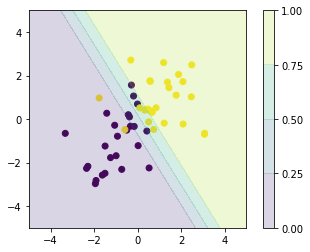

In [14]:
x_train, y_train = create_toy_data()
x1_test, x2_test = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
x_test = np.array([x1_test, x2_test]).reshape(2, -1).T

feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = LogisticRegression()
model.fit(X_train, y_train)
y = model.proba(X_test)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1_test, x2_test, y.reshape(100, 100), np.linspace(0, 1, 5), alpha=0.2)
plt.colorbar()
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Softmax回归

In [18]:
class LabelTransformer(object):
    """label encoder decoder
    
    Attr
    ====
    n_classes: int
        number of classes
    """
    def __init__(self, n_classes=None):
        self.n_classes = n_classes

    @property
    def n_classes(self):
        return self.__n_classes

    @n_classes.setter
    def n_classes(self, K):
        self.__n_classes = K
        self.__encoder = None if K is None else np.eye(K)

    @property
    def encoder(self):
        return self.__encoder

    def encode(self, class_indices):
        """encode class index into one-of-k code
        
        Params
        ======
        class_indices: ndarray with shape (N,)
            non-negative class index
            elements must be integer in [0, n_classes)
        
        Returns
        =======
        output: ndarrray with shape (N, K)
            one-of-k encoding of input
        """
        if self.n_classes is None:
            self.n_classes = np.max(class_indices) + 1

        return self.encoder[class_indices]

    def decode(self, onehot):
        """ decode one-of-k code into class index
        
        Params
        ======
        onehot: ndarray with shape (N, K)
            one-of-k code
        
        Returns
        =======
        output: ndarray with shape (N,)
            class index
        """
        return np.argmax(onehot, axis=1)

In [19]:
class SoftmaxRegression(object):
    """
    Softmax regression model
    aka
    multinomial logistic regression,
    multiclass logistic regression,
    maximum entropy classifier.

    y = softmax(X @ W)
    t ~ Categorical(t|y)
    """

    @staticmethod
    def _softmax(a):
        a_max = np.max(a, axis=-1, keepdims=True)
        exp_a = np.exp(a - a_max)
        return exp_a / np.sum(exp_a, axis=-1, keepdims=True)

    def fit(self, X, t, max_iter=100, learning_rate=0.1):
        """
        maximum likelihood estimation of the parameter

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) or (N, K) np.ndarray
            training dependent variable
            in class index or one-of-k encoding
        max_iter : int, optional
            maximum number of iteration (the default is 100)
        learning_rate : float, optional
            learning rate of gradient descent (the default is 0.1)
        """
        if t.ndim == 1:
            t = LabelTransformer().encode(t)
        self.n_classes = np.size(t, 1)
        W = np.zeros((np.size(X, 1), self.n_classes))
        for _ in range(max_iter):
            W_prev = np.copy(W)
            y = self._softmax(X @ W)
            grad = X.T @ (y - t)
            W -= learning_rate * grad
            if np.allclose(W, W_prev):
                break
        self.W = W

    def proba(self, X:np.ndarray):
        """
        compute probability of input belonging each class

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable

        Returns
        -------
        (N, K) np.ndarray
            probability of each class
        """
        return self._softmax(X @ self.W)

    def classify(self, X:np.ndarray):
        """
        classify input data

        Parameters
        ----------
        X : (N, D) np.ndarray
            independent variable to be classified

        Returns
        -------
        (N,) np.ndarray
            class index for each input
        """
        return np.argmax(self.proba(X), axis=-1)


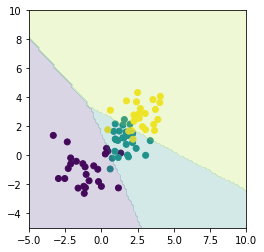

In [20]:
x_train, y_train = create_toy_data(add_class=True)
x1, x2 = np.meshgrid(np.linspace(-5, 10, 100), np.linspace(-5, 10, 100))
x = np.array([x1, x2]).reshape(2, -1).T

feature = PolynomialFeature(1)
X_train = feature.transform(x_train)
X = feature.transform(x)

model = SoftmaxRegression()
model.fit(X_train, y_train, max_iter=1000, learning_rate=0.01)
y = model.classify(X)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.contourf(x1, x2, y.reshape(100, 100), alpha=0.2, levels=np.array([0., 0.5, 1.5, 2.]))
plt.xlim(-5, 10)
plt.ylim(-5, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()